In [30]:
import sys
sys.path.append("../deep-learning-dna")
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
import wandb
from lmdbm import Lmdb
import settransformer as st
from common.models import CustomModel
from common.models import dnabert
import os, glob

In [4]:
class ContiguousMask(keras.layers.Layer):
    """
    Mask out contiguous blocks of input tokens (provided as integers)
    """
    def __init__(self, mask_ratio, **kwargs):
        super().__init__(**kwargs)
        self.mask_ratio = tf.Variable(
            mask_ratio, trainable=False, dtype=tf.float32, name="Mask_Ratio")

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        mask_len = tf.cast(tf.cast(seq_len, dtype=tf.float32) * self.mask_ratio, dtype=tf.int32)

        # Pick random mask offsets
        mask_offsets = tf.random.uniform((batch_size,), minval=0, maxval=(seq_len - mask_len + 1), dtype=tf.int32)

        # Construct and the mask
        left = tf.sequence_mask(mask_offsets, seq_len)
        right = tf.logical_not(tf.sequence_mask(mask_offsets + mask_len, seq_len))
        mask = tf.cast(tf.logical_or(left, right), dtype=inputs.dtype)

        # Return the masked inputs, and the mask
        return mask * inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "mask_ratio": self.mask_ratio.numpy()
        })
        return config

class InvertMask(keras.layers.Layer):
    """
    Invert the current mask. Useful for DNABERT models where we *want* to pay attention to the
    masked elements.
    """
    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        return tf.logical_not(mask)

    def call(self, inputs):
        # tf.print(inputs)
        # tf.print(inputs + 0)
        return inputs + 0 # hacky, but without modification

In [5]:
class SetMask(keras.layers.Layer):
    def __init__(self, mask_ratio, **kwargs):
        super().__init__(**kwargs)
        self.mask_ratio = tf.Variable(mask_ratio, trainable=False, dtype=tf.float32, name='Mask_Ratio')
        
    def call(self, inputs, mask=None):
        mask = self.compute_mask(inputs, mask)
        return tf.cast(mask, dtype=tf.float32) * inputs
    
    def compute_mask(self, inputs, mask):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        embed_dim = tf.shape(inputs)[2]
        mask_len = tf.cast(tf.cast(seq_len, dtype=tf.float32) * self.mask_ratio, dtype=tf.int32)
        
        random = tf.random.uniform((batch_size, seq_len), 0, 1)
        values, indices = tf.math.top_k(random, mask_len)
        batch_indices = tf.reshape(tf.repeat(tf.range(batch_size), mask_len), (-1,1))
        embedding_indices = tf.reshape(indices, (-1, 1))
        indices = tf.concat((batch_indices, embedding_indices), axis=1)
        mask = tf.ones((batch_size, seq_len))
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.zeros((batch_size * mask_len)))
        mask = tf.tile(tf.expand_dims(mask, axis=2), (1, 1, embed_dim))
        return tf.cast(mask, dtype=tf.bool)

In [6]:
class SetClassToken(keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.class_token = self.add_weight(shape=(1, 1, embedding_dim), initializer='random_normal',
                                           trainable=True, name='Class_token')
    
    def compute_mask(self, inputs, mask):
        batch_size = tf.shape(inputs)[0]
        token_mask = tf.ones((batch_size, 1, self.embedding_dim), dtype=tf.bool)
        return tf.concat((token_mask, mask), axis=1)
    
    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        tokens = tf.tile(self.class_token, (batch_size, 1, 1))
        return tf.concat((tokens, inputs), axis=1)

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, subsample_size, num_batches, rng=None):
        super().__init__()
        self.samples = [Lmdb.open(s, lock=False) for s in samples]
        self.batch_size = batch_size
        self.subsample_size = subsample_size
        self.num_batches = num_batches
        self.rng = rng if rng is not None else np.random.default_rng()
        
    def __getitem__(self, i):
        batch = []
        sample_indices = self.rng.integers(len(self.samples), size=self.batch_size)
        for si in sample_indices:
            indices = self.rng.choice(len(self.samples[si]), self.subsample_size, replace=False)
            pre_embeddings = []
            for i in indices:
                pre_embeddings.append(np.asarray(np.frombuffer(self.samples[si][i.__str__()], dtype=np.float32)))
            batch.append(pre_embeddings)
            
        return np.array(batch), np.array(batch)
    
    def __len__(self):
        return self.num_batches

In [8]:
class SubBatchModel(CustomModel):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)
    
    def compute_mask(self, inputs, mask):
        return mask

In [63]:
samples = []
path = './pre_embedded_samples/train'
for filename in glob.glob(os.path.join(path, '*.db')):
    if filename != './pre_embedded_samples/train/Wes24-PCRblank2_S25_L001_R1_001.db':
        if filename != './pre_embedded_samples/train/Wes7-PCRblank1_S8_L001_R1_001.db':
            samples.append(filename)
samples

['./pre_embedded_samples/train/WS-MR-Jul2015_S26_L001_R1_001.db',
 './pre_embedded_samples/train/Wes9-5-AG_S10_L001_R1_001.db',
 './pre_embedded_samples/train/Wesley018-HN-072820_S157_L001_R1_001.db',
 './pre_embedded_samples/train/WS-WH-Oct2016_S87_L001_R1_001.db',
 './pre_embedded_samples/train/Wesley002-MR-051220_S141_L001_R1_001.db',
 './pre_embedded_samples/train/WS-HF-Jul2015_S42_L001_R1_001.db',
 './pre_embedded_samples/train/WS-SB-Oct2016_S63_L001_R1_001.db',
 './pre_embedded_samples/train/WS-WH-Sep2015_S59_L001_R1_001.db',
 './pre_embedded_samples/train/WS-MR-Sep2015_S67_L001_R1_001.db',
 './pre_embedded_samples/train/WS-AG-Jul2015_S3_L001_R1_001.db',
 './pre_embedded_samples/train/Wes53-10-SOY_S54_L001_R1_001.db',
 './pre_embedded_samples/train/WS-MR-Jul2016_S54_L001_R1_001.db',
 './pre_embedded_samples/train/Wes49-10-SB_S50_L001_R1_001.db',
 './pre_embedded_samples/train/WS-HF-May2015_S9_L001_R1_001.db',
 './pre_embedded_samples/train/Wes29-8-SB_S30_L001_R1_001.db',
 './pre_

In [58]:
samples[108]

'./pre_embedded_samples/train/Wes7-PCRblank1_S8_L001_R1_001.db'

In [64]:
for i, sample in enumerate(samples):
    sample_open = Lmdb.open(sample, lock=False)
    print(i, len(sample_open))

0 69119
1 112424
2 23133
3 68789
4 19206
5 64658
6 65256
7 68837
8 74652
9 72832
10 113622
11 70973
12 76439
13 63417
14 89170
15 15282
16 20621
17 20173
18 119490
19 69189
20 114038
21 71228
22 19265
23 69583
24 18310
25 15165
26 19060
27 18248
28 68550
29 14791
30 24111
31 74556
32 65370
33 13949
34 18905
35 118085
36 37099
37 134351
38 71434
39 73181
40 66360
41 67807
42 74557
43 71374
44 16321
45 73115
46 69761
47 69444
48 63593
49 66231
50 68635
51 164014
52 68162
53 20642
54 13839
55 86037
56 112290
57 91613
58 16040
59 60984
60 17512
61 71234
62 89828
63 77379
64 19598
65 17508
66 66324
67 11203
68 70305
69 83444
70 3628
71 163925
72 17256
73 75450
74 18881
75 70205
76 67760
77 156929
78 17481
79 67365
80 66279
81 82351
82 73234
83 84362
84 148236
85 63916
86 73012
87 78462
88 80294
89 16127
90 67377
91 72676
92 14606
93 64459
94 91321
95 76797
96 62932
97 71553
98 137497
99 135181
100 69464
101 124994
102 67942
103 108908
104 66124
105 20734
106 78550
107 132558
108 75333
109 7

In [65]:
seq_gen = DataGenerator(samples, 32, 1000, 20)

In [66]:
input_layer = keras.layers.Input((1000, 8))
masking_layer = SetMask(mask_ratio=0.15)
masked = masking_layer(input_layer)
class_tokens = SetClassToken(8)
tokens_added = class_tokens(masked)
for i in range(8):
    ISAB = st.ISAB(8, 2, 30)
    tokens_added = ISAB(tokens_added)
inverted_mask = InvertMask()(tokens_added)
output = keras.layers.Lambda(lambda x: x[:, 1:, :])(inverted_mask)
class_token_embeddings = keras.layers.Lambda(lambda x: x[:, 0, :])(inverted_mask)

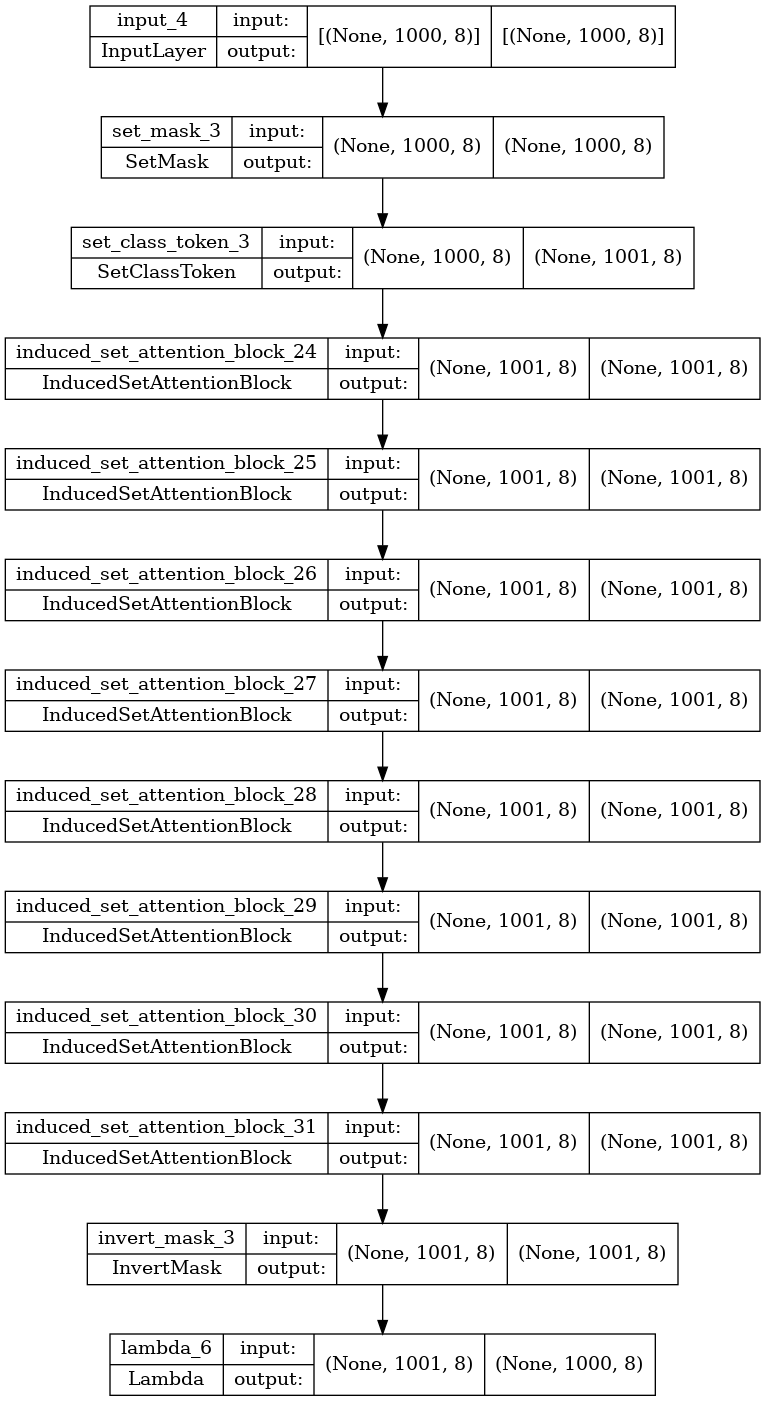

In [67]:
setbert = SubBatchModel(keras.Model(input_layer, output))
keras.utils.plot_model(setbert.model,show_shapes=True,expand_nested=True)

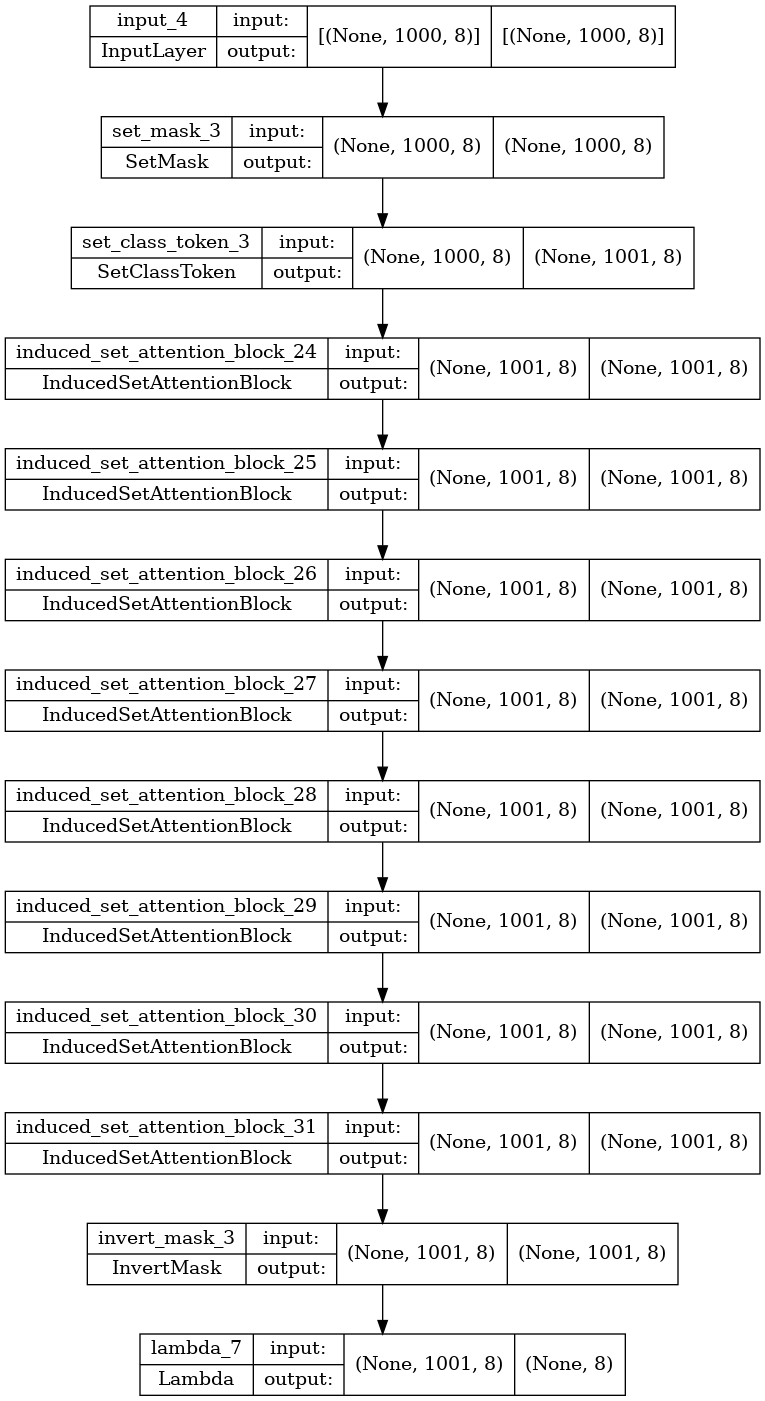

In [68]:
setbert_tokens = SubBatchModel(keras.Model(input_layer, class_token_embeddings))
keras.utils.plot_model(setbert_tokens.model,show_shapes=True,expand_nested=True)

In [69]:
setbert_tokens.predict(seq_gen[0][0], batch_size=8)

array([[-1.08816612e+00, -9.02550817e-02,  9.75013256e-01,
        -2.05375671e+00,  2.70730644e-01,  2.75519729e-01,
         7.40664005e-01,  9.70250249e-01],
       [-1.06318021e+00, -2.87096724e-02,  1.02441144e+00,
        -2.06925821e+00,  2.04404816e-01,  2.72310078e-01,
         6.82022274e-01,  9.77999389e-01],
       [-1.19384384e+00, -8.08249041e-02,  9.86306965e-01,
        -1.96455717e+00,  1.61439478e-01,  2.95002759e-01,
         8.30570936e-01,  9.65905964e-01],
       [-1.28112459e+00,  6.13045394e-02,  1.10000622e+00,
        -1.35551989e+00, -8.03853154e-01, -2.71050744e-02,
         1.17661572e+00,  1.12967634e+00],
       [-1.09562695e+00, -6.90012276e-02,  9.87078607e-01,
        -2.04735732e+00,  2.31782883e-01,  2.78246343e-01,
         7.40623951e-01,  9.74253595e-01],
       [-1.18890536e+00, -1.11867376e-01,  9.86892998e-01,
        -1.97192895e+00,  2.27096945e-01,  2.88768798e-01,
         8.13513756e-01,  9.56429422e-01],
       [-1.27907741e+00,  9.436691

In [70]:
setbert.compile(optimizer=keras.optimizers.Nadam(1e-4), loss=tf.keras.losses.LogCosh())

In [73]:
history = setbert.fit(seq_gen, epochs=300, subbatch_size=8)

Epoch 1/300
20/20 [==============================] - 4s 199ms/step - loss: 3.2772
Epoch 2/300
20/20 [==============================] - 4s 204ms/step - loss: 3.2764
Epoch 3/300
20/20 [==============================] - 4s 200ms/step - loss: 3.2705
Epoch 4/300
20/20 [==============================] - 4s 204ms/step - loss: 3.2782
Epoch 5/300
20/20 [==============================] - 4s 196ms/step - loss: 3.2730
Epoch 6/300
20/20 [==============================] - 4s 200ms/step - loss: 3.2692
Epoch 7/300
20/20 [==============================] - 4s 202ms/step - loss: 3.2729
Epoch 8/300
20/20 [==============================] - 4s 201ms/step - loss: 3.2768
Epoch 9/300
20/20 [==============================] - 4s 200ms/step - loss: 3.2724
Epoch 10/300
20/20 [==============================] - 4s 203ms/step - loss: 3.2838
Epoch 11/300
20/20 [==============================] - 4s 198ms/step - loss: 3.2766
Epoch 12/300
20/20 [==============================] - 4s 197ms/step - loss: 3.2736
Epoch 13/300


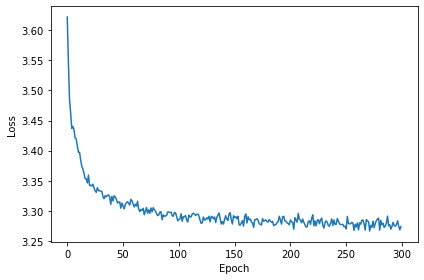

In [72]:
plt.figure(1) 
plt.plot(history.history['loss']) 
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

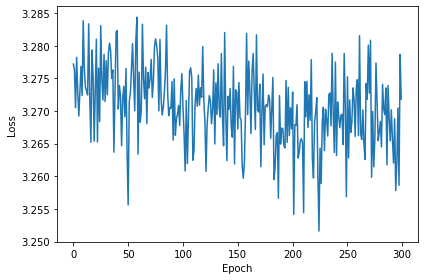

In [74]:
plt.figure(1) 
plt.plot(history.history['loss']) 
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [81]:
seq_gen_collection = []
for sample in samples:
    seq_gen = DataGenerator([sample], 32, 1000, 20)
    seq_gen_collection.append(seq_gen)

In [87]:
class_tokens1 = setbert_tokens.predict(seq_gen_collection[0][0][0])
print(class_tokens1)
class_tokens2 = setbert_tokens.predict(seq_gen_collection[1][0][0])
print(class_tokens2)

[[-0.6555897   0.7766448   1.3407886  -0.46673107  1.1243737  -1.3785725
   0.4991104  -1.2400243 ]
 [-0.6347037   0.7748633   1.321456   -0.42798907  1.113425   -1.3961008
   0.517978   -1.2689288 ]
 [-0.66310334  0.80518556  1.327834   -0.548771    1.1072553  -1.3549702
   0.5461606  -1.2195909 ]
 [-0.68227994  0.72916174  1.3628958  -0.37889382  1.1275575  -1.3661613
   0.4842322  -1.2765124 ]
 [-0.7921196   0.7319556   1.3868512  -0.48044363  1.1565489  -1.2328866
   0.48928696 -1.2591927 ]
 [-0.6784716   0.8184443   1.3627589  -0.5590982   1.1045487  -1.2825484
   0.49526137 -1.260895  ]
 [-0.6208813   0.77416587  1.3456596  -0.50831956  1.1205022  -1.3430043
   0.50806236 -1.2761849 ]
 [-0.59292746  0.7443502   1.3428532  -0.49317333  1.1041353  -1.3814654
   0.54871726 -1.2724894 ]
 [-0.65411174  0.80832624  1.3183088  -0.5172883   1.1156564  -1.3728952
   0.52851766 -1.2265137 ]
 [-0.66092205  0.7295241   1.3388395  -0.2916142   1.1156825  -1.4246266
   0.4779161  -1.2847991 ]


In [94]:
class_tokens = []
for seq_gen in seq_gen_collection:
    class_tokens.append(setbert_tokens.predict(seq_gen[0][0]))

In [95]:
class_tokens = np.concatenate(class_tokens)

In [96]:
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

In [97]:
dist_mat = cdist(class_tokens, class_tokens)
dist_mat

array([[0.        , 0.16850939, 0.10514864, ..., 0.48184279, 0.41250683,
        0.5460758 ],
       [0.16850939, 0.        , 0.12705458, ..., 0.46303967, 0.41836269,
        0.53403202],
       [0.10514864, 0.12705458, 0.        , ..., 0.53122408, 0.47043337,
        0.60243501],
       ...,
       [0.48184279, 0.46303967, 0.53122408, ..., 0.        , 0.09538057,
        0.0919915 ],
       [0.41250683, 0.41836269, 0.47043337, ..., 0.09538057, 0.        ,
        0.15171165],
       [0.5460758 , 0.53403202, 0.60243501, ..., 0.0919915 , 0.15171165,
        0.        ]])

In [100]:
dist_mat.shape

(6656, 6656)

In [101]:
mds = MDS(metric=True, dissimilarity='precomputed', n_jobs=10)

In [102]:
points = mds.fit_transform(dist_mat)

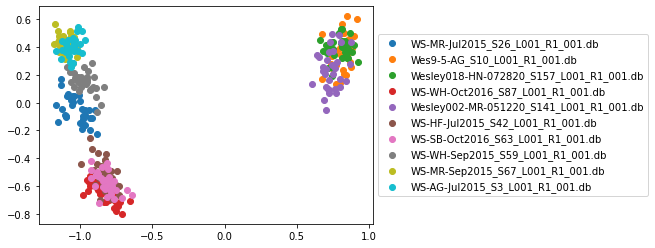

In [123]:
for cluster in points.reshape(len(samples), 32, 2)[:10]:
    plt.scatter(*cluster.T)
plt.legend([os.path.basename(s) for s in samples[:10]], loc='center left', bbox_to_anchor=(1., 0.5))